In [1]:
import keras
import tensorflow as tf
from keras import utils, layers
from keras_vggface.vggface import VGGFace
from keras.layers import Flatten, Dense, Input, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [2]:
data_dir = './dataset_2/train/'
test_dir = './dataset_2/test/'

# Conjunto de treinamento (80% dos dados)
train_dt = utils.image_dataset_from_directory(data_dir,
                                        shuffle=True,
                                        batch_size=8,
                                        image_size=(224, 224),
                                        validation_split=0.2,  
                                        subset="training",    
                                        seed=123)             

validation_data = utils.image_dataset_from_directory(test_dir,
                                               shuffle=True,
                                               batch_size=8,
                                               image_size=(224, 224),
                                               seed=123)  

Found 16160 files belonging to 20 classes.
Using 12928 files for training.
Found 3998 files belonging to 20 classes.


In [3]:
# Obter os nomes das classes
class_names = train_dt.class_names
print(len(class_names))
print(f"Classes disponíveis: {class_names}")

with open('names.txt', 'w') as file:
    for item in class_names:
        file.write(f"{item}\n")  # Escreve cada item em uma nova linha

20
Classes disponíveis: ['adam_sandler', 'beyonce', 'chris_rock', 'denzel_washington', 'dwayne_johnson', 'eddie_murphy', 'jamie_fox', 'jason_statham', 'johnny_depp', 'lebron_james', 'martin_lawrane', 'nicolas_cage', 'robert_downey_jr', 'sydney_sweeney', 'timothee_chalamet', 'tom_cruise', 'tom_holland', 'viola_davis', 'will_smith', 'zendaya']


In [4]:
data_aug = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2)
])

In [9]:
vggface_resnet_base = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3))

In [10]:
nb_class = len(class_names)

# Freeze the base model
vggface_resnet_base.trainable = False
last_layer = vggface_resnet_base.get_layer('avg_pool').output

# Build up the new model
inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_aug(inputs)

x = vggface_resnet_base(x)

x = Flatten(name='flatten')(x)

x = Dense(2024, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

out = Dense(nb_class, activation='softmax', name='classifier')(x)

custom_vgg_model = keras.Model(inputs, out)

In [11]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',        # Métrica que o callback monitora
    patience=5,                # Número de épocas sem melhoria antes de parar o treinamento
    min_delta=0.001,           # Mudança mínima para ser considerada como melhoria
    restore_best_weights=True  # Restaurar os pesos do modelo da melhor época
)   

In [12]:
import keras.losses
from keras.metrics import Precision

base_learning_rate = 0.0001

custom_vgg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                         loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['accuracy'])

custom_vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vggface_resnet50 (Functiona  (None, 1, 1, 2048)       23561152  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2024)              4147176   
                                                                 
 dropout (Dropout)           (None, 2024)              0         
                                                             

In [13]:
history = custom_vgg_model.fit(
    train_dt, 
    validation_data=validation_data,
    epochs=180
)

Epoch 1/180


c:\Users\Roberto Alves\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1616/1616 [==============================] - 61s 34ms/step - loss: 1.7377 - accuracy: 0.5246 - val_loss: 0.0571 - val_accuracy: 0.9822
Epoch 2/180
1616/1616 [==============================] - 53s 33ms/step - loss: 0.9370 - accuracy: 0.7173 - val_loss: 0.0556 - val_accuracy: 0.9827
Epoch 3/180
1616/1616 [==============================] - 52s 32ms/step - loss: 0.8256 - accuracy: 0.7485 - val_loss: 0.0658 - val_accuracy: 0.9812
Epoch 4/180
1616/1616 [==============================] - 53s 33ms/step - loss: 0.7464 - accuracy: 0.7748 - val_loss: 0.0495 - val_accuracy: 0.9855
Epoch 5/180
1616/1616 [==============================] - 55s 34ms/step - loss: 0.6741 - accuracy: 0.7946 - val_loss: 0.0459 - val_accuracy: 0.9862
Epoch 6/180
1616/1616 [==============================] - 55s 34ms/step - loss: 0.6477 - accuracy: 0.8008 - val_loss: 0.0531 - val_accuracy: 0.9862
Epoch 7/180
1616/1616 [==============================] - 59s 37ms/step - loss: 0.6181 - accuracy: 0.8113 - val_loss: 0.0806 - val_

In [14]:
prob_model = keras.Sequential([
    custom_vgg_model,
    tf.keras.layers.Softmax()
])

1/1 [==============================] - 0s 19ms/step


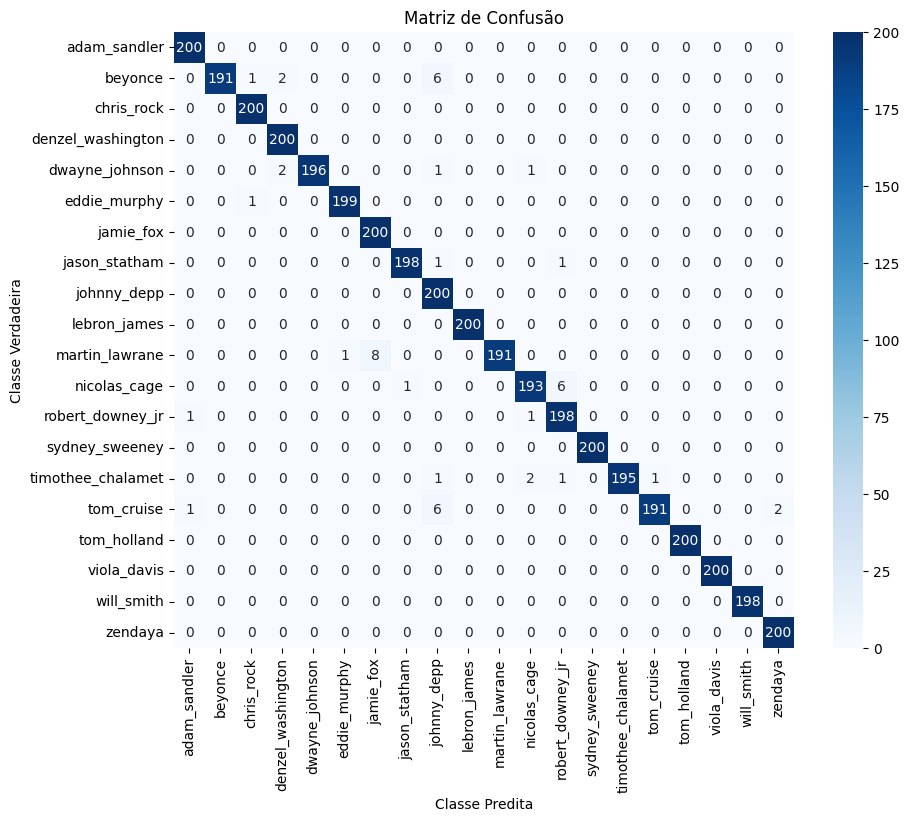

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.utils import load_img, img_to_array

# Gerar previsões para o conjunto de teste
true_labels = []
pred_labels = []

# Iterate over validation/test dataset
for images, labels in validation_data:  # Assumindo que você tenha um dataset de validação/teste
    # Armazenar os rótulos verdadeiros
    true_labels.extend(labels)
    
    # Fazer previsões para cada batch
    predictions = prob_model.predict(images)
    
    # Armazenar as classes previstas
    pred_labels.extend(np.argmax(predictions, axis=1))

# Gerar a matriz de confusão
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Visualizar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_dt.class_names, yticklabels=train_dt.class_names)
plt.title('Matriz de Confusão')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.show()


In [15]:
prob_model.save('face_recognition0-dataset2.h5')

In [ ]:
from keras.models import load_model
from keras.utils import load_img, img_to_array
import numpy as np

# Carregar o modelo
modelo_carregado = load_model('face_recognition0-dataset2.h5')  # ou 'meu_modelo' para o formato SavedModel

# Carregar a imagem e redimensioná-la para o tamanho esperado
img_path = './download.jpg'
img = load_img(img_path, target_size=(224, 224))

# Converter a imagem para um array NumPy
img_array = img_to_array(img)

# Adicionar uma dimensão extra para representar o batch (necessário para a entrada do modelo)
img_array = np.expand_dims(img_array, axis=0)

# Usar o modelo para previsões
predictions = modelo_carregado.predict(img_array)

predicted_class_index = np.argmax(predictions)
print(predicted_class_index)
# Exibir a classe predita
predicted_class = class_names[predicted_class_index]
print(f"A classe predita é: {predicted_class}")


1/1 [==============================] - 1s 781ms/step
[[0.04604416 0.04604416 0.04604416 0.04604416 0.04604416 0.04604416
  0.04604416 0.04604416 0.04604416 0.04604416 0.04604416 0.12516098
  0.04604416 0.04604416 0.04604416 0.04604416 0.04604416 0.04604416
  0.04604416 0.04604416]]
1/1 [==============================] - 0s 18ms/step
[[0.04604473 0.04604473 0.04604473 0.04604473 0.04604473 0.04604473
  0.04604473 0.04604473 0.04604473 0.04604473 0.04604473 0.12514283
  0.04604473 0.04604473 0.04604473 0.04604631 0.04605041 0.04604473
  0.04604473 0.04604473]]
1/1 [==============================] - 0s 20ms/step
[[0.04604416 0.04604416 0.04604416 0.04604416 0.04604416 0.04604416
  0.04604416 0.04604416 0.04604416 0.04604416 0.04604416 0.12516098
  0.04604416 0.04604416 0.04604416 0.04604416 0.04604416 0.04604416
  0.04604416 0.04604416]]
1/1 [==============================] - 0s 17ms/step
[[0.0469194  0.0469194  0.0469194  0.0469194  0.0469194  0.0469194
  0.0469194  0.0469194  0.0469194 

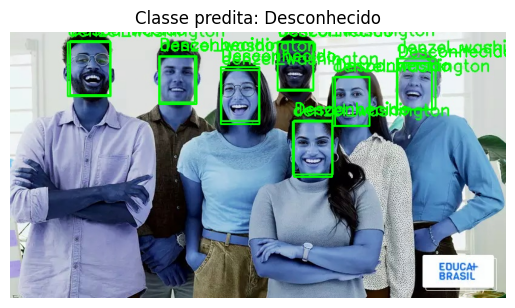

In [21]:
from keras.models import load_model
from keras.utils import load_img, img_to_array
import numpy as np
from mtcnn import MTCNN
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

import os
# Forçar o uso da CPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"



# Inicializar o detector de rostos MTCNN
detector = MTCNN()

def preprocess_image(image_path):
    """Aplica pré-processamento básico à imagem"""
    img = load_img(image_path, target_size=(224, 224))  # Ajuste o tamanho para o esperado pelo modelo
    img_array = img_to_array(img)
    return img_array.astype('uint8')

def extract_faces(image):
    """Detecta e extrai faces da imagem usando MTCNN"""
    pixels = np.asarray(image)
    results = detector.detect_faces(pixels)
    faces = []
    for result in results:
        x, y, width, height = result['box']
        x, y = abs(x), abs(y)  # Garantir coordenadas positivas
        face = pixels[y:y+height, x:x+width]
        face = Image.fromarray(face).resize((224, 224))  # Redimensionar para 224x224
        face = np.asarray(face)
        faces.append(face)
    return faces


def get_boxes_from_image(image):
    """Detecta e extrai faces da imagem usando MTCNN"""
    pixels = np.asarray(image)
    results = detector.detect_faces(pixels)
    boxes = []
    for result in results:
        x, y, width, height = result['box']
        x, y = abs(x), abs(y)  # Garantir coordenadas positivas
        boxes.append((x, y, width, height))  # Salva as coordenadas da caixa do rosto

    return boxes

def augment_image(image):
    """Aumenta a imagem aplicando várias transformações"""
    augmented_images = [image]

    # Flip horizontal
    augmented_images.append(cv2.flip(image, 1))

    # Rotate 10 degrees
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols/2, rows/2), 10, 1)
    augmented_images.append(cv2.warpAffine(image, M, (cols, rows)))

    # Rotate -10 degrees
    M = cv2.getRotationMatrix2D((cols/2, rows/2), -10, 1)
    augmented_images.append(cv2.warpAffine(image, M, (cols, rows)))

    # Brightness adjustment
    bright_image = cv2.convertScaleAbs(image, alpha=1.2, beta=30)
    augmented_images.append(bright_image)

    # Contrast adjustment
    contrast_image = cv2.convertScaleAbs(image, alpha=1.5, beta=0)
    augmented_images.append(contrast_image)

    # Zoom in
    zoom_factor = 1.2
    zoomed_image = cv2.resize(image, None, fx=zoom_factor, fy=zoom_factor)
    center_x, center_y = zoomed_image.shape[1]//2, zoomed_image.shape[0]//2
    crop_x, crop_y = cols//2, rows//2
    zoomed_image = zoomed_image[center_y-crop_y:center_y+crop_y, center_x-crop_x:center_x+crop_x]
    augmented_images.append(zoomed_image)

    # Shift (Translation)
    shift_x, shift_y = 20, 20
    M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    shifted_image = cv2.warpAffine(image, M, (cols, rows))
    augmented_images.append(shifted_image)

    # Gaussian blur
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    augmented_images.append(blurred_image)

    return augmented_images


# Carregar o modelo treinado
modelo_carregado = load_model('trainer.h5')

# Carregar e pré-processar a imagem
img_path = './test.jpg'
original_image = cv2.imread(img_path)
img_p = preprocess_image(img_path)
faces = extract_faces(img_p)
boxes = get_boxes_from_image(original_image)


if not faces:
    print(f"Rosto não encontrado na imagem {img_path}")
else:
    all_predictions = []
    confidence_values = {}  # Dicionário para armazenar valores de confiança por classe

    # Para cada face detectada
    for i, face in enumerate(faces):
        augmented_faces = augment_image(face)
        for j, aug_face in enumerate(augmented_faces):
            # Adicionar uma dimensão extra para representar o batch
            face_batch = np.expand_dims(aug_face, axis=0)  # O modelo espera uma entrada com formato (1, 224, 224, 3)
            # Fazer a previsão usando o modelo
            predictions = modelo_carregado.predict(face_batch)
            print(predictions)

            # Obter o índice da classe prevista e a confiança
            predicted_class_index = np.argmax(predictions)
            confidence = predictions[0][predicted_class_index]  # Confiança da classe prevista
            confidence_value = confidence * 100  # Converte a confiança para porcentagem
            all_predictions.append(predicted_class_index)

            # Adiciona o valor de confiança à lista correspondente à classe
            if predicted_class_index not in confidence_values:
                confidence_values[predicted_class_index] = []
            confidence_values[predicted_class_index].append(confidence_value)

    # Contar a quantidade de previsões por classe
    prediction_counts = Counter(all_predictions)

    most_frequent_class = None
    most_frequent_count = 0

    # Encontrar a classe com mais previsões
    for class_index, count in prediction_counts.items():
        if count > most_frequent_count:
            most_frequent_class = class_index
            most_frequent_count = count

    # Verificar os valores de confiança da classe mais frequente
    if most_frequent_class is not None:
        confidences = confidence_values[most_frequent_class]  # Obter os valores de confiança dessa classe
        value_counts = Counter(confidences)  # Contar as ocorrências de cada valor de confiança

        most_common_value, most_common_count = value_counts.most_common(1)[0]

        if most_common_count <= 6:
            predicted_class = "Desconhecido"
        else:
            predicted_class = class_names[most_frequent_class]
    else:
        print("Nenhuma predição foi feita.")

    # Desenhar o quadrado ao redor do rosto na imagem original
    for (x, y, width, height) in boxes:
        # Desenhar o quadrado na imagem original
        cv2.rectangle(original_image, (x, y), (x + width, y + height), (0, 255, 0), 2)
        # Adicionar o nome da classe predita na imagem
        cv2.putText(original_image, predicted_class, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Exibir a imagem com o quadrado e a classe predita
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))  # Converte para RGB para exibição correta
    plt.title(f"Classe predita: {predicted_class}")
    plt.axis('off')
    plt.show()


In [21]:
import tensorflow as tf
tf.keras.utils.disable_interactive_logging()
from keras.models import load_model
from keras.utils import load_img, img_to_array
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


modelo_carregado = load_model('face_recognition0-dataset2.h5')  # ou 'meu_modelo' para o formato SavedModel

y_true = []
y_pred_classes = []

i = 0
# Iterate over validation/test dataset
for images, labels in validation_data:  # Assumindo que você tenha um dataset de validação/teste

    # Armazenar os rótulos verdadeiros
    print(f"Labels {i}: ", labels)
    y_true.extend(labels)
    
    # Fazer previsões para cada batch
    predictions = modelo_carregado.predict(images)
    
    # Armazenar as classes previstas
    print(f"Classes previstar {i}: ", np.argmax(predictions, axis=1))
    y_pred_classes.extend(np.argmax(predictions, axis=1))

    i = i + 1

# Calcular as métricas
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
cm = confusion_matrix(y_true, y_pred_classes)
report = classification_report(y_true, y_pred_classes, target_names=class_names)

# Exibir os resultados
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{cm}')
print(f'Classification Report:\n{report}')

Labels 0:  tf.Tensor([ 8  0  3 13  3 10  1 11], shape=(8,), dtype=int32)
Classes previstar 0:  [ 8  0  3 13  3 10  1 11]
Labels 1:  tf.Tensor([18  6  2 17 12 17 12 11], shape=(8,), dtype=int32)
Classes previstar 1:  [18  6  2 17 12 17 12 11]
Labels 2:  tf.Tensor([15 18  2  6  0  2 12 10], shape=(8,), dtype=int32)
Classes previstar 2:  [15 18  2  6  0  2 12 10]
Labels 3:  tf.Tensor([13 10 12  5 16 16 10  8], shape=(8,), dtype=int32)
Classes previstar 3:  [13 10 12  5 16 16 10  8]
Labels 4:  tf.Tensor([ 6 11 17 13  9 16  0 13], shape=(8,), dtype=int32)
Classes previstar 4:  [ 6 11 17 13  9 16  0 13]
Labels 5:  tf.Tensor([ 6  8  4  4 10 17 16 12], shape=(8,), dtype=int32)
Classes previstar 5:  [ 6  8  4  4 10 17 16 12]
Labels 6:  tf.Tensor([ 1 13 10 14 15  9  0 15], shape=(8,), dtype=int32)
Classes previstar 6:  [ 1 13 10 14 15  9  0 15]
Labels 7:  tf.Tensor([ 2 19 11  6 15 16  4  8], shape=(8,), dtype=int32)
Classes previstar 7:  [ 2 19 11  6 15 16  4  8]
Labels 8:  tf.Tensor([11  4  8 1